# 6_CVClasificacion_LFW
1. Consulte y presente el modelo y problema de optimización de los siguientes clasificadores:

### Naive_Bayes.GaussianNB

Dado un vector de características $\mathbf{x} = (x_1, x_2, \dots, x_d) $, se desea predecir la clase $C_k$ que maximiza la probabilidad posterior:

$\hat{y} = \arg\max_{C_k} P(C_k \mid \mathbf{x}) = \arg\max_{C_k} \frac{P(\mathbf{x} \mid C_k) P(C_k)}{P(\mathbf{x})}$

En lugar de realizar uns optimización numérica tradicional, aprende los parámetros de media y varianza de forma analítica.
### SGDClassifier
**Modelo**: Clasificador lineal (por ejemplo, regresión logística o SVM) entrenado mediante Stochastic Gradient Descent.

**Problema de optimización**:

Para Regresión logística: $\min_w \frac{1}{n} \sum_{i=1}^{n} \log(1 + e^{-y_i w^T x_i}) + \alpha \|w\|^2$

Para SVM: $\min_w \frac{1}{n} \sum_{i=1}^{n} \max(0, 1 - e^{-y_i w^T x_i}) + \alpha \|w\|^2$

Utiliza la optimización de descenso de gradiente estocástico, donde en cada iteración se calcula la función de costo y se actualizan los parámetros en base a su gradiente con una fuerza decreciente (learning rate)

### LogisticRegression
**Modelo**:  Clasificador lineal que estima probabilidades mediante la función sigmoide

$p(A|x)=\frac{1}{1+e^{w^T x+b}}=sigmoid(w^T x+)$

**Problema de optimización** $\min_w \frac{1}{n} \sum_{i=1}^{n} \log(1 + e^{-y_i w^T x_i}) + \alpha \|w\|^2$

Se optimiza generalmente con solucionadores como newton, sag o lbfgs.

### LinearDiscriminantAnalysis

Supone distribución Gaussiana de las clases con la misma matriz de covarianza. Proyecta datos a un espacio lineal.

Para predecir un dato maximiza la razón entre varianza entre clases y varianza dentro de las clases.

$\text{Maximizar } \frac{|w^T S_B w|}{|w^T S_W w|}$

Donde $S_W$ es la matriz de dispersión intra-clase y $S_B$ entre clases.

**Optimización**: Solución analítica de un problema de autovalores $S^{-1}_W S_B$


### KNeighborsClassifier
Este es un modelo no paramétrico el cual clasifica un punto según los k vecinos más cercanos

$\hat{y} = \text{mode}(y_i \text{ de los } k \text{ vecinos más cercanos})$

Al no ser un modelo paramétrico no cuenta con optimización.

### LinearSVC

**Modelo**: Utiliza el modelo de SVMs como clasificador con un kernel lineal:

**Problema de optimización**: $\min_w \frac{1}{2} \|w\|^2 + C \sum_{i=1}^n \max(0, 1 - y_i w^T x_i)$

Es computacionalmente más rápida y tiene mayor flexibilidad en sus hiperparámtros en comparación con el siguiente modelo:
### SVC
** Modelo**: Es un SVM con Kernel

** Prolema de optimización**: $\max_\alpha \sum_i \alpha_i - \frac{1}{2} \sum_{i,j} \alpha_i \alpha_j y_i y_j K(x_i, x_j)$

La operación de optimización se suele hacer con algoritmos como SMO (Sequential Minimal Optimization)

### RandomForestClassifier
**Modelo**: Conjunto de desiciones de cada arbol:

$\hat{y} = \text{majority\_vote}(h_1(x), h_2(x), ..., h_T(x))$

**Optimización**: Cada árbol se construye para minimizar el Gini impurity o la entropía en los nodos. No hay una función de optimización global, sino una búsqueda voraz local.

2. Utilizando un esquema de validación cruzada de 5 folds sobre el conjunto de entrenamiento, compare el rendimiento de los métodos del punto 1. Emplee optimización Bayesiana de hiperparámetros, fijando el score en términos del acc, el f1 y el AUC.

In [1]:
!pip install optuna
#librerias a importar
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import roc_curve, auc
from itertools import cycle

import warnings
warnings.filterwarnings("ignore")

#crear carpeta resultados
try:
  os.mkdir('results')
except:
  print("Carpeta results ya existe")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 24.2 MB/s eta 0:00:00


Dimensiones tipo pandas:  (1288, 1850)
Dimensiones tipo imágen: (1288, 50, 37)


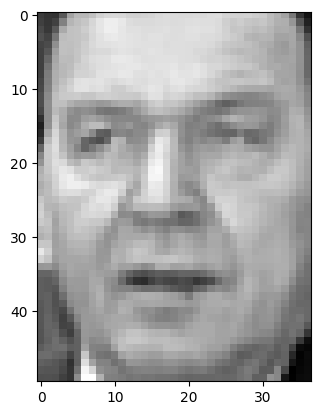

In [2]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
# datos tipo pandas
Xdata = pd.DataFrame(lfw_people.data)/255
y = lfw_people.target
print('Dimensiones tipo pandas: ',Xdata.shape)
print('Dimensiones tipo imágen:',lfw_people.images.shape)
plt.imshow(np.array(Xdata.iloc[300,:]).reshape(lfw_people.images.shape[1],
                                             lfw_people.images.shape[2]),cmap='gray')
plt.show()

In [3]:
#Particion entrenamiento y evaluación
# Tamaño Xtrain 70%, Tamaño Xtest 30%
Xtrain, Xtest, ytrain,ytest = train_test_split(Xdata,y,test_size=0.3, random_state=123)
Xtrain.head()

,0,1,2,3,4,5,6,7,8,9,...,1840,1841,1842,1843,1844,1845,1846,1847,1848,1849
510,0.000836,0.001143,0.001446,0.001666,0.001897,0.001994,0.002066,0.002071,0.002097,0.002138,...,0.000549,0.001384,0.002332,0.003189,0.003645,0.003727,0.003101,0.000856,0.000395,0.000466
1035,0.001589,0.001758,0.001922,0.002409,0.002819,0.002958,0.002917,0.002830,0.002830,0.002737,...,0.000297,0.000374,0.000384,0.000436,0.000359,0.000369,0.000420,0.000497,0.000466,0.000466
176,0.000892,0.001205,0.001210,0.001287,0.001492,0.001687,0.001763,0.001779,0.001845,0.001866,...,0.000451,0.000446,0.000482,0.000472,0.000477,0.000466,0.000513,0.000559,0.000600,0.000538
620,0.000267,0.000584,0.001446,0.002230,0.002507,0.002512,0.002491,0.002532,0.002584,0.002594,...,0.001333,0.001389,0.000723,0.000133,0.000190,0.000251,0.000313,0.000400,0.000549,0.000666
689,0.002261,0.002409,0.001958,0.001753,0.002127,0.002907,0.002932,0.002676,0.002655,0.002799,...,0.001569,0.001512,0.001548,0.001615,0.001794,0.002276,0.003106,0.003522,0.003573,0.003578


In [4]:
import optuna
import joblib
import os
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from cuml.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from cuml.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from cuml.neighbors import KNeighborsClassifier
from cuml.svm import LinearSVC, SVC
from cuml.ensemble import RandomForestClassifier

# RAPIDS (si están disponibles)
try:
    from cuml.linear_model import LogisticRegression as cuLogisticRegression
    from cuml.svm import SVC as cuSVC
    cuml_available = True
except ImportError:
    cuml_available = False

# Crear carpeta para guardar modelos
os.makedirs("results", exist_ok=True)

# Supón que ya tienes tus datos:
# Xtrain, ytrain = ...

# Lista de clasificadores
model_configs = []

# 1. GaussianNB
model_configs.append({
    "n_trials": 1,
    "label": "GaussianNB",
    "model_fn": lambda trial: GaussianNB(),
    "param_space": lambda trial: {}
})

# 2. SGDClassifier
model_configs.append({
    "n_trials": 30,
    "label": "SGDClassifier",
    "model_fn": lambda trial: SGDClassifier(
        alpha=trial.suggest_loguniform('alpha', 1e-4, 1e2),
        max_iter=1000),
    "param_space": lambda trial: {'alpha': trial.suggest_loguniform('alpha', 1e-4, 1e2)}
})

# 3. LogisticRegression
model_configs.append({
    "n_trials": 5,
    "label": "LogisticRegression",
    "model_fn": lambda trial: LogisticRegression(
        C=trial.suggest_loguniform('C', 1e-3, 1e3),
        max_iter=1000),
    "param_space": lambda trial: {'C': trial.suggest_loguniform('C', 1e-3, 1e3)}
})

# 4. LinearDiscriminantAnalysis
model_configs.append({
    "n_trials": 1,
    "label": "LinearDiscriminantAnalysis",
    "model_fn": lambda trial: LinearDiscriminantAnalysis(),
    "param_space": lambda trial: {}
})

# 5. KNeighborsClassifier
model_configs.append({
    "n_trials": 5,
    "label": "KNeighborsClassifier",
    "model_fn": lambda trial: KNeighborsClassifier(
        n_neighbors=trial.suggest_int('n_neighbors', 3, 15)),
    "param_space": lambda trial: {'n_neighbors': trial.suggest_int('n_neighbors', 3, 15)}
})

# 6. LinearSVC
model_configs.append({
    "n_trials": 10,
    "label": "LinearSVC",
    "model_fn": lambda trial: LinearSVC(
        C=trial.suggest_loguniform('C', 1e-3, 1e3),
        max_iter=10000),
    "param_space": lambda trial: {'C': trial.suggest_loguniform('C', 1e-3, 1e3)}
})

model_configs.append({
    "label": "SVC",
    "n_trials": 20,
    "model_fn": lambda trial: SVC(
        C=trial.suggest_loguniform('C', 1e-1, 1e4),
        gamma=trial.suggest_loguniform('gamma', 1e-3, 10)),
    "param_space": lambda trial: {
        'C': trial.suggest_loguniform('C', 1e-1, 1e4),
        'gamma': trial.suggest_loguniform('gamma', 1e-3, 10)
    }
})

# 8. RandomForestClassifier
model_configs.append({
    "n_trials": 20,
    "label": "RandomForestClassifier",
    "model_fn": lambda trial: RandomForestClassifier(
        n_estimators=trial.suggest_int('n_estimators', 50, 300),
        max_depth=trial.suggest_int('max_depth', 3, 30)),
    "param_space": lambda trial: {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 30)
    }
})

cv_results = {}

# Entrenamiento + optimización con Optuna
for config in model_configs:
    fold_scores = []
    print(f"\n🔍 Optimizando modelo: {config['label']}")

    def objective(trial):
        model = config['model_fn'](trial)
        pipe = Pipeline([
            ('nor', MinMaxScaler()),
            ('cla', model)
        ])
        score = cross_val_score(pipe, Xtrain, ytrain, cv=5, scoring='accuracy')
        fold_scores.append(score)
        return score.mean()


    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=config["n_trials"])

    # Almacena resultados estadísticos
    all_scores = np.array(fold_scores)
    best_idx = np.argmax([np.mean(s) for s in all_scores])
    best_scores = all_scores[best_idx]

    cv_results[config['label']] = {
        "mean": np.mean(best_scores),
        "std": np.std(best_scores),
        "fold_scores": best_scores.tolist()
    }

    print(f"✅ Mejor score para {config['label']}: {study.best_value}")
    print(f"📊 Mejores hiperparámetros: {study.best_params}")

    # Entrena modelo final con mejores parámetros
    best_model = config['model_fn'](optuna.trial.FixedTrial(study.best_params))
    best_pipeline = Pipeline([
        ('nor', MinMaxScaler()),
        ('cla', best_model)
    ])
    best_pipeline.fit(Xtrain, ytrain)
    joblib.dump(best_pipeline, f"results/{config['label']}.pkl")

[I 2025-06-12 17:32:39,735] A new study created in memory with name: no-name-6abe19c9-604f-465e-a43f-571686fbc51d



🔍 Optimizando modelo: GaussianNB


[I 2025-06-12 17:32:47,558] Trial 0 finished with value: 0.3762492326580724 and parameters: {}. Best is trial 0 with value: 0.3762492326580724.
[I 2025-06-12 17:32:47,702] A new study created in memory with name: no-name-29a8b413-e03a-402d-8854-688e2c30b73e


✅ Mejor score para GaussianNB: 0.3762492326580724
📊 Mejores hiperparámetros: {}

🔍 Optimizando modelo: SGDClassifier


[I 2025-06-12 17:32:50,744] Trial 0 finished with value: 0.7302823818293431 and parameters: {'alpha': 0.0016470400409708474}. Best is trial 0 with value: 0.7302823818293431.
[I 2025-06-12 17:32:52,913] Trial 1 finished with value: 0.5016574585635359 and parameters: {'alpha': 2.025683902564053}. Best is trial 0 with value: 0.7302823818293431.
[I 2025-06-12 17:32:54,170] Trial 2 finished with value: 0.4761632903621854 and parameters: {'alpha': 4.595863190540541}. Best is trial 0 with value: 0.7302823818293431.
[I 2025-06-12 17:32:57,169] Trial 3 finished with value: 0.7379987722529159 and parameters: {'alpha': 0.0023074160510681216}. Best is trial 3 with value: 0.7379987722529159.
[I 2025-06-12 17:33:00,119] Trial 4 finished with value: 0.7646531614487415 and parameters: {'alpha': 0.002100435700594696}. Best is trial 4 with value: 0.7646531614487415.
[I 2025-06-12 17:33:01,144] Trial 5 finished with value: 0.4173235113566605 and parameters: {'alpha': 36.588760260998605}. Best is trial 4 

✅ Mejor score para SGDClassifier: 0.7802332719459791
📊 Mejores hiperparámetros: {'alpha': 0.0005913541323778568}


[I 2025-06-12 17:34:15,655] A new study created in memory with name: no-name-e24cbc64-ba39-49de-bca2-6a5bb826c883



🔍 Optimizando modelo: LogisticRegression
[2025-06-12 17:34:18.154] [CUML] [warning] L-BFGS: max iterations reached
[2025-06-12 17:34:18.156] [CUML] [warning] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[2025-06-12 17:34:18.915] [CUML] [warning] L-BFGS: max iterations reached
[2025-06-12 17:34:18.917] [CUML] [warning] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[2025-06-12 17:34:19.546] [CUML] [warning] L-BFGS: max iterations reached
[2025-06-12 17:34:19.547] [CUML] [warning] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[2025-06-12 17:34:20.012] [CUML] [warning] L-BFGS: max iterations reached
[2

[I 2025-06-12 17:34:20,516] Trial 0 finished with value: 0.8135174953959483 and parameters: {'C': 10.944715951928583}. Best is trial 0 with value: 0.8135174953959483.


[2025-06-12 17:34:20.498] [CUML] [warning] L-BFGS: max iterations reached
[2025-06-12 17:34:20.499] [CUML] [warning] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.


[I 2025-06-12 17:34:21,696] Trial 1 finished with value: 0.6947759361571517 and parameters: {'C': 0.027609440339418045}. Best is trial 0 with value: 0.8135174953959483.


[2025-06-12 17:34:21.682] [CUML] [warning] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[2025-06-12 17:34:23.118] [CUML] [warning] L-BFGS: max iterations reached
[2025-06-12 17:34:23.119] [CUML] [warning] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[2025-06-12 17:34:23.836] [CUML] [warning] L-BFGS: max iterations reached
[2025-06-12 17:34:23.839] [CUML] [warning] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.


[I 2025-06-12 17:34:24,324] Trial 2 finished with value: 0.8124125230202578 and parameters: {'C': 4.301102199967432}. Best is trial 0 with value: 0.8135174953959483.


[2025-06-12 17:34:24.309] [CUML] [warning] L-BFGS: max iterations reached
[2025-06-12 17:34:24.310] [CUML] [warning] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[2025-06-12 17:34:24.840] [CUML] [warning] L-BFGS: max iterations reached
[2025-06-12 17:34:24.841] [CUML] [warning] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[2025-06-12 17:34:25.330] [CUML] [warning] L-BFGS: max iterations reached
[2025-06-12 17:34:25.332] [CUML] [warning] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[2025-06-12 17:34:25.833] [CUML] [warning] L-BFGS: max iterations reached
[2025-06-12 17:34:25.835] [CUML] [warning] M

[I 2025-06-12 17:34:26,823] Trial 3 finished with value: 0.8102025782688764 and parameters: {'C': 353.9783757769792}. Best is trial 0 with value: 0.8135174953959483.


[2025-06-12 17:34:27.282] [CUML] [warning] L-BFGS: max iterations reached
[2025-06-12 17:34:27.283] [CUML] [warning] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[2025-06-12 17:34:27.754] [CUML] [warning] L-BFGS: max iterations reached
[2025-06-12 17:34:27.756] [CUML] [warning] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.


[I 2025-06-12 17:34:29,135] Trial 4 finished with value: 0.81463474524248 and parameters: {'C': 4.010562492236763}. Best is trial 4 with value: 0.81463474524248.


[2025-06-12 17:34:29.121] [CUML] [warning] L-BFGS: max iterations reached
[2025-06-12 17:34:29.122] [CUML] [warning] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
✅ Mejor score para LogisticRegression: 0.81463474524248
📊 Mejores hiperparámetros: {'C': 4.010562492236763}


[I 2025-06-12 17:34:29,668] A new study created in memory with name: no-name-eef5bde8-936d-4da9-a020-b993786c2d3e


[2025-06-12 17:34:29.660] [CUML] [warning] L-BFGS: max iterations reached
[2025-06-12 17:34:29.664] [CUML] [warning] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.

🔍 Optimizando modelo: LinearDiscriminantAnalysis


[I 2025-06-12 17:34:33,998] Trial 0 finished with value: 0.7069551872314304 and parameters: {}. Best is trial 0 with value: 0.7069551872314304.


✅ Mejor score para LinearDiscriminantAnalysis: 0.7069551872314304
📊 Mejores hiperparámetros: {}


[I 2025-06-12 17:34:34,695] A new study created in memory with name: no-name-c60fa1be-76b5-48c4-9f67-7893ad34f817



🔍 Optimizando modelo: KNeighborsClassifier
[2025-06-12 17:34:34.700] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization


[I 2025-06-12 17:34:35,482] Trial 0 finished with value: 0.5616206261510129 and parameters: {'n_neighbors': 7}. Best is trial 0 with value: 0.5616206261510129.


[2025-06-12 17:34:35.328] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization
[2025-06-12 17:34:35.370] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization
[2025-06-12 17:34:35.407] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization
[2025-06-12 17:34:35.444] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization
[2025-06-12 17:34:35.485] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization
[2025-06-12 17:34:35.523] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization


[I 2025-06-12 17:34:35,667] Trial 1 finished with value: 0.5282811540822591 and parameters: {'n_neighbors': 3}. Best is trial 0 with value: 0.5616206261510129.


[2025-06-12 17:34:35.561] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization
[2025-06-12 17:34:35.597] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization
[2025-06-12 17:34:35.632] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization
[2025-06-12 17:34:35.670] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization
[2025-06-12 17:34:35.709] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization
[2025-06-12 17:34:35.745] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization


[I 2025-06-12 17:34:35,860] Trial 2 finished with value: 0.5383118477593616 and parameters: {'n_neighbors': 15}. Best is trial 0 with value: 0.5616206261510129.


[2025-06-12 17:34:35.786] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization
[2025-06-12 17:34:35.822] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization
[2025-06-12 17:34:35.864] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization
[2025-06-12 17:34:35.921] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization
[2025-06-12 17:34:35.962] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization


[I 2025-06-12 17:34:36,120] Trial 3 finished with value: 0.5416267648864335 and parameters: {'n_neighbors': 14}. Best is trial 0 with value: 0.5616206261510129.


[2025-06-12 17:34:36.029] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization
[2025-06-12 17:34:36.079] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization
[2025-06-12 17:34:36.125] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization
[2025-06-12 17:34:36.161] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization
[2025-06-12 17:34:36.198] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization


[I 2025-06-12 17:34:36,313] Trial 4 finished with value: 0.552744014732965 and parameters: {'n_neighbors': 10}. Best is trial 0 with value: 0.5616206261510129.
[I 2025-06-12 17:34:36,348] A new study created in memory with name: no-name-66a32e57-e70d-433e-9902-3db2be08f213


[2025-06-12 17:34:36.240] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization
[2025-06-12 17:34:36.278] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization
✅ Mejor score para KNeighborsClassifier: 0.5616206261510129
📊 Mejores hiperparámetros: {'n_neighbors': 7}

🔍 Optimizando modelo: LinearSVC
[2025-06-12 17:34:37.118] [CUML] [warning] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)


[I 2025-06-12 17:34:43,759] Trial 0 finished with value: 0.797986494782075 and parameters: {'C': 41.69096838761422}. Best is trial 0 with value: 0.797986494782075.
[I 2025-06-12 17:34:45,964] Trial 1 finished with value: 0.7880110497237569 and parameters: {'C': 905.7683277785936}. Best is trial 0 with value: 0.797986494782075.


[2025-06-12 17:34:47.451] [CUML] [warning] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)


[I 2025-06-12 17:34:47,962] Trial 2 finished with value: 0.7957765500306936 and parameters: {'C': 773.4470739672288}. Best is trial 0 with value: 0.797986494782075.


[2025-06-12 17:34:51.120] [CUML] [warning] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)


[I 2025-06-12 17:34:51,753] Trial 3 finished with value: 0.8057397176181705 and parameters: {'C': 0.04534962010990945}. Best is trial 3 with value: 0.8057397176181705.
[I 2025-06-12 17:34:54,511] Trial 4 finished with value: 0.5682688766114181 and parameters: {'C': 0.0017107104237241667}. Best is trial 3 with value: 0.8057397176181705.
[I 2025-06-12 17:34:57,597] Trial 5 finished with value: 0.7924677716390424 and parameters: {'C': 397.7123781375647}. Best is trial 3 with value: 0.8057397176181705.


[2025-06-12 17:34:57.938] [CUML] [warning] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[2025-06-12 17:35:01.232] [CUML] [warning] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[2025-06-12 17:35:02.951] [CUML] [warning] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[2025-06-12 17:35:03.161] [CUML] [warning] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)


[I 2025-06-12 17:35:03,938] Trial 6 finished with value: 0.8079864947820751 and parameters: {'C': 3.596011551115359}. Best is trial 6 with value: 0.8079864947820751.


[2025-06-12 17:35:07.409] [CUML] [warning] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[2025-06-12 17:35:08.503] [CUML] [warning] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)


[I 2025-06-12 17:35:09,040] Trial 7 finished with value: 0.8013259668508287 and parameters: {'C': 143.6359812680567}. Best is trial 6 with value: 0.8079864947820751.


[2025-06-12 17:35:09.628] [CUML] [warning] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[2025-06-12 17:35:10.674] [CUML] [warning] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)


[I 2025-06-12 17:35:11,611] Trial 8 finished with value: 0.6448680171884591 and parameters: {'C': 0.0035260273752930546}. Best is trial 6 with value: 0.8079864947820751.


[2025-06-12 17:35:13.252] [CUML] [warning] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[2025-06-12 17:35:16.233] [CUML] [warning] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)


[I 2025-06-12 17:35:18,196] Trial 9 finished with value: 0.8079987722529159 and parameters: {'C': 3.1974618148062066}. Best is trial 9 with value: 0.8079987722529159.


✅ Mejor score para LinearSVC: 0.8079987722529159
📊 Mejores hiperparámetros: {'C': 3.1974618148062066}
[2025-06-12 17:35:19.351] [CUML] [warning] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)


[I 2025-06-12 17:35:19,742] A new study created in memory with name: no-name-5ebf54c6-1a21-4fad-affa-22d3fd221a47



🔍 Optimizando modelo: SVC


[I 2025-06-12 17:35:22,877] Trial 0 finished with value: 0.411767955801105 and parameters: {'C': 27.945678837021397, 'gamma': 1.6368144767236885}. Best is trial 0 with value: 0.411767955801105.
[I 2025-06-12 17:35:25,430] Trial 1 finished with value: 0.411767955801105 and parameters: {'C': 11.307501200776043, 'gamma': 0.9238245688340998}. Best is trial 0 with value: 0.411767955801105.
[I 2025-06-12 17:35:28,023] Trial 2 finished with value: 0.411767955801105 and parameters: {'C': 3500.2410326158606, 'gamma': 0.4237481591926979}. Best is trial 0 with value: 0.411767955801105.
[I 2025-06-12 17:35:30,708] Trial 3 finished with value: 0.411767955801105 and parameters: {'C': 0.13961450657828453, 'gamma': 7.827836481227963}. Best is trial 0 with value: 0.411767955801105.
[I 2025-06-12 17:35:33,476] Trial 4 finished with value: 0.7236402701043585 and parameters: {'C': 34.58219799522384, 'gamma': 0.026937408273477036}. Best is trial 4 with value: 0.7236402701043585.
[I 2025-06-12 17:35:36,124]

✅ Mejor score para SVC: 0.8068692449355431
📊 Mejores hiperparámetros: {'C': 5854.262646206243, 'gamma': 0.0030903045520407676}


[I 2025-06-12 17:36:14,919] A new study created in memory with name: no-name-06ce6242-36ff-48e3-b139-b8c5eb5e782b



🔍 Optimizando modelo: RandomForestClassifier


[I 2025-06-12 17:36:22,321] Trial 0 finished with value: 0.5982811540822591 and parameters: {'n_estimators': 275, 'max_depth': 16}. Best is trial 0 with value: 0.5982811540822591.
[I 2025-06-12 17:36:24,406] Trial 1 finished with value: 0.5893677102516882 and parameters: {'n_estimators': 72, 'max_depth': 26}. Best is trial 0 with value: 0.5982811540822591.
[I 2025-06-12 17:36:26,111] Trial 2 finished with value: 0.4706015960712094 and parameters: {'n_estimators': 77, 'max_depth': 3}. Best is trial 0 with value: 0.5982811540822591.
[I 2025-06-12 17:36:32,683] Trial 3 finished with value: 0.5938367096378147 and parameters: {'n_estimators': 299, 'max_depth': 9}. Best is trial 0 with value: 0.5982811540822591.
[I 2025-06-12 17:36:35,225] Trial 4 finished with value: 0.5860466543891958 and parameters: {'n_estimators': 90, 'max_depth': 13}. Best is trial 0 with value: 0.5982811540822591.
[I 2025-06-12 17:36:37,925] Trial 5 finished with value: 0.5904726826273787 and parameters: {'n_estimator

✅ Mejor score para RandomForestClassifier: 0.6027133210558625
📊 Mejores hiperparámetros: {'n_estimators': 217, 'max_depth': 30}


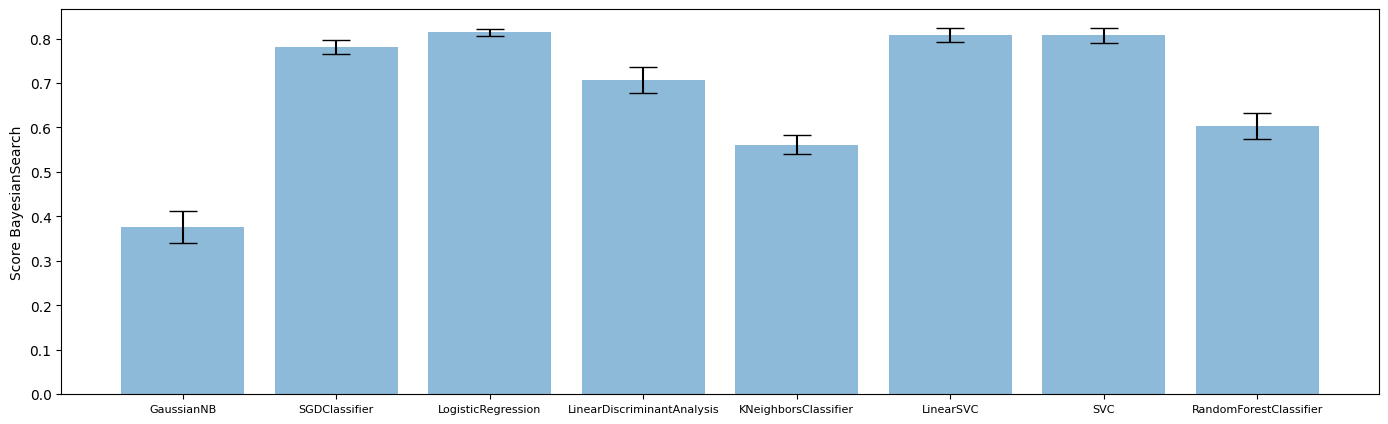

In [22]:
#recorrer modelos
plt.figure(figsize=(17, 5))

bars_ = np.zeros((2,len(cv_results.keys())))#arreglo de barras para graficar mejores modelos en promedio con std
for n, i in enumerate(cv_results.keys()):
  bars_[0,n] = cv_results[i]['mean']#guardar score promedio del mejor modelo
  bars_[1,n] = cv_results[i]['std']#guardar std del mejor modelo

plt.bar(np.arange(len(cv_results)), bars_[0], yerr=bars_[1], align='center', alpha=0.5, ecolor='black', capsize=10)
plt.ylabel('Score BayesianSearch')
plt.xticks(np.arange(len(cv_results.keys())))
plt.gca().set_xticklabels(cv_results.keys(), fontsize=8)
plt.show()

Evaluando modelo LogisticRegression


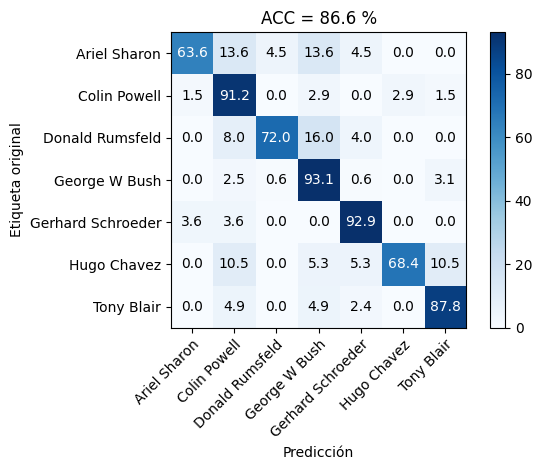

                   precision    recall  f1-score   support

     Ariel Sharon       0.88      0.64      0.74        22
     Colin Powell       0.79      0.91      0.85        68
  Donald Rumsfeld       0.95      0.72      0.82        50
    George W Bush       0.90      0.93      0.92       159
Gerhard Schroeder       0.81      0.93      0.87        28
      Hugo Chavez       0.87      0.68      0.76        19
       Tony Blair       0.82      0.88      0.85        41

         accuracy                           0.87       387
        macro avg       0.86      0.81      0.83       387
     weighted avg       0.87      0.87      0.86       387

Evaluando modelo SVC


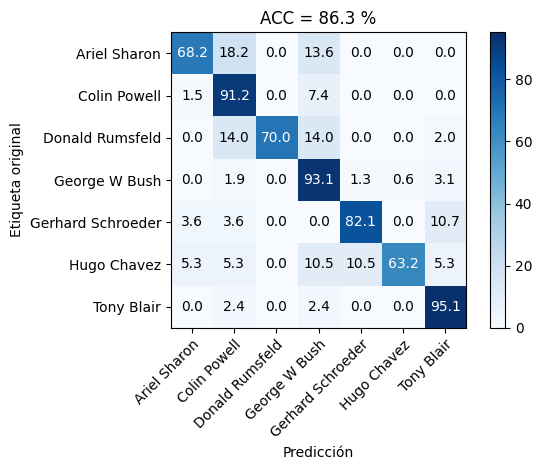

                   precision    recall  f1-score   support

     Ariel Sharon       0.83      0.68      0.75        22
     Colin Powell       0.78      0.91      0.84        68
  Donald Rumsfeld       1.00      0.70      0.82        50
    George W Bush       0.89      0.93      0.91       159
Gerhard Schroeder       0.85      0.82      0.84        28
      Hugo Chavez       0.92      0.63      0.75        19
       Tony Blair       0.80      0.95      0.87        41

         accuracy                           0.86       387
        macro avg       0.87      0.80      0.83       387
     weighted avg       0.87      0.86      0.86       387

Evaluando modelo LinearSVC


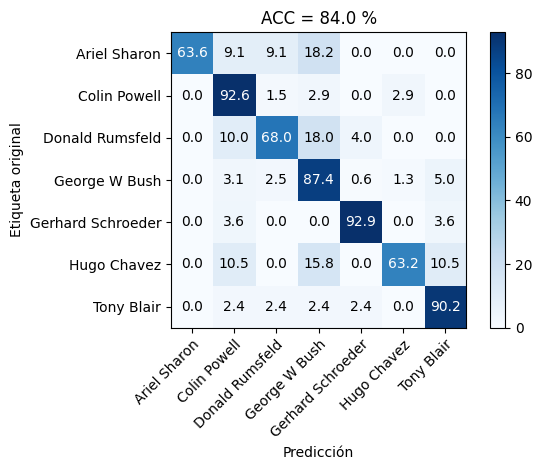

                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.64      0.78        22
     Colin Powell       0.80      0.93      0.86        68
  Donald Rumsfeld       0.81      0.68      0.74        50
    George W Bush       0.88      0.87      0.88       159
Gerhard Schroeder       0.87      0.93      0.90        28
      Hugo Chavez       0.75      0.63      0.69        19
       Tony Blair       0.77      0.90      0.83        41

         accuracy                           0.84       387
        macro avg       0.84      0.80      0.81       387
     weighted avg       0.84      0.84      0.84       387

Evaluando modelo LinearDiscriminantAnalysis


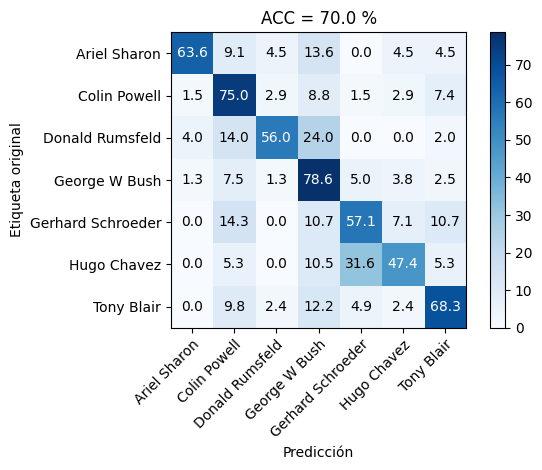

                   precision    recall  f1-score   support

     Ariel Sharon       0.74      0.64      0.68        22
     Colin Powell       0.63      0.75      0.68        68
  Donald Rumsfeld       0.82      0.56      0.67        50
    George W Bush       0.80      0.79      0.79       159
Gerhard Schroeder       0.48      0.57      0.52        28
      Hugo Chavez       0.43      0.47      0.45        19
       Tony Blair       0.65      0.68      0.67        41

         accuracy                           0.70       387
        macro avg       0.65      0.64      0.64       387
     weighted avg       0.71      0.70      0.70       387

Evaluando modelo KNeighborsClassifier


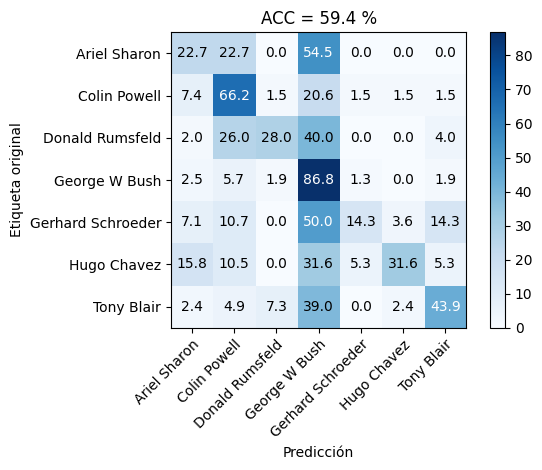

                   precision    recall  f1-score   support

     Ariel Sharon       0.24      0.23      0.23        22
     Colin Powell       0.57      0.66      0.61        68
  Donald Rumsfeld       0.67      0.28      0.39        50
    George W Bush       0.63      0.87      0.73       159
Gerhard Schroeder       0.50      0.14      0.22        28
      Hugo Chavez       0.67      0.32      0.43        19
       Tony Blair       0.62      0.44      0.51        41

         accuracy                           0.59       387
        macro avg       0.56      0.42      0.45       387
     weighted avg       0.59      0.59      0.56       387

Evaluando modelo GaussianNB


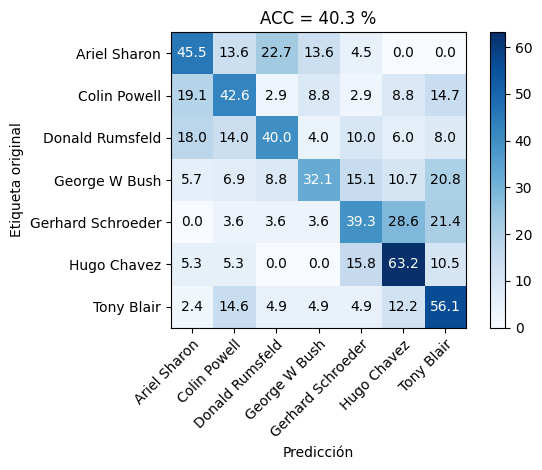

                   precision    recall  f1-score   support

     Ariel Sharon       0.23      0.45      0.31        22
     Colin Powell       0.50      0.43      0.46        68
  Donald Rumsfeld       0.45      0.40      0.43        50
    George W Bush       0.78      0.32      0.46       159
Gerhard Schroeder       0.23      0.39      0.29        28
      Hugo Chavez       0.24      0.63      0.34        19
       Tony Blair       0.29      0.56      0.39        41

         accuracy                           0.40       387
        macro avg       0.39      0.46      0.38       387
     weighted avg       0.54      0.40      0.42       387

Evaluando modelo SGDClassifier


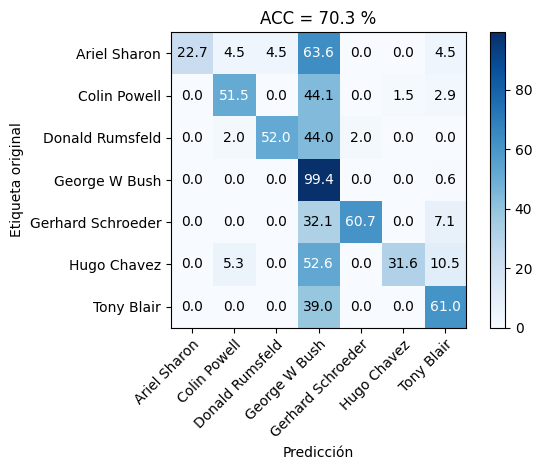

                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.23      0.37        22
     Colin Powell       0.92      0.51      0.66        68
  Donald Rumsfeld       0.96      0.52      0.68        50
    George W Bush       0.61      0.99      0.76       159
Gerhard Schroeder       0.94      0.61      0.74        28
      Hugo Chavez       0.86      0.32      0.46        19
       Tony Blair       0.76      0.61      0.68        41

         accuracy                           0.70       387
        macro avg       0.86      0.54      0.62       387
     weighted avg       0.78      0.70      0.68       387

Evaluando modelo RandomForestClassifier


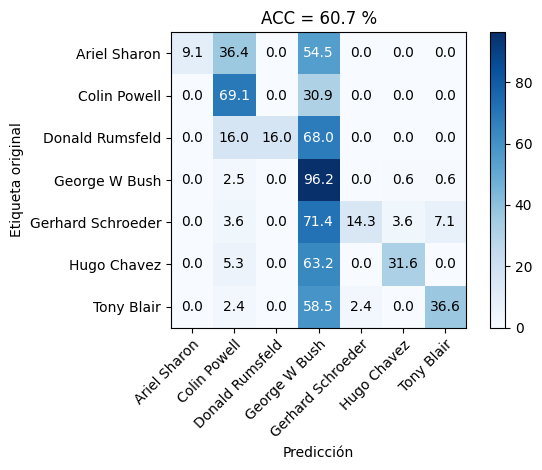

                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.09      0.17        22
     Colin Powell       0.67      0.69      0.68        68
  Donald Rumsfeld       1.00      0.16      0.28        50
    George W Bush       0.55      0.96      0.70       159
Gerhard Schroeder       0.80      0.14      0.24        28
      Hugo Chavez       0.75      0.32      0.44        19
       Tony Blair       0.83      0.37      0.51        41

         accuracy                           0.61       387
        macro avg       0.80      0.39      0.43       387
     weighted avg       0.71      0.61      0.55       387



In [5]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    gráfica la matriz de confusión con y sin normalización
    """
    if not title:
        title = 'Matriz de confusión'

    # calcular matriz de confusión
    cm = 100*confusion_matrix(y_true, y_pred,normalize="true")
    # se identifican las etiquetas en los datos
    classes = classes[unique_labels(y_true, y_pred)]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # mostrar ticks
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Etiqueta original',
           xlabel='Predicción')

    # Rotar ticks
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # textos.
    fmt = '.1f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

#%% evaluar sobre Xtest
path_img = ''
for filename in os.listdir("results/"):
    model = joblib.load("results/" + filename)
    print('Evaluando modelo %s' % (filename[:-4]))

    ytest_e = model.predict(Xtest)
    acc = accuracy_score(ytest,ytest_e)

    plot_confusion_matrix(
                          ytest, ytest_e,
                          classes=lfw_people.target_names,
                          title='ACC = %.1f %%' % (100*acc)
                          )
    plt.autoscale()
    #save_fig(path_img,label_models[i])
    plt.show()

    cr = classification_report(
                               ytest, ytest_e,
                               labels=range(lfw_people.target_names.shape[0]),
                               target_names=lfw_people.target_names
                               )
    #support = #muestras en la clase estudiada
    print(cr)

In [6]:
from sklearn.preprocessing import label_binarize
import seaborn as sns

def roc_auc_mc(roc_auc,fpr,tpr,n_classes,title,path_img):
    lw = 2
    # Falsos positivos
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    # roc
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i]) #interpolar para suavizar
    # promediado sobre numero de clases
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # graficar
    plt.figure(figsize=(6,6))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    #colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    colors = sns.color_palette(None, n_classes)
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='AUC_class_{0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="best")#,bbox_to_anchor=(1.4, 0.75))
    plt.show()


def roc_multiclass(ytrue,yscore):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = ytrue.shape[1]
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(ytrue[:, i], yscore[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Calcular micro-average ROC curve y ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(ytrue.ravel(), yscore.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    return roc_auc, fpr, tpr, n_classes

ytrain_b = label_binarize(ytrain, classes=range(lfw_people.target_names.shape[0]))
ytest_b = label_binarize(ytest, classes=range(lfw_people.target_names.shape[0]))

for filename in os.listdir("results/"):
    model = joblib.load("results/" + filename)
    print('Evaluando modelo %s' % (filename[:-4]))
    #debe calcularse la funcion de decision o el posterior de la probabilidad
    try:
        ytest_score = model.decision_function(Xtest)
        roc_auc, fpr, tpr, n_classes = roc_multiclass(ytest_b,ytest_score)
        roc_auc_mc(roc_auc,fpr,tpr,n_classes,'ROC curve ' + label_models[i],path_img)
    except:
        print("El modelo %s no tiene función de decisión" % filename[:-4])

Evaluando modelo LogisticRegression
El modelo LogisticRegression no tiene función de decisión
Evaluando modelo SVC
El modelo SVC no tiene función de decisión
Evaluando modelo LinearSVC
El modelo LinearSVC no tiene función de decisión
Evaluando modelo LinearDiscriminantAnalysis
El modelo LinearDiscriminantAnalysis no tiene función de decisión
Evaluando modelo KNeighborsClassifier
El modelo KNeighborsClassifier no tiene función de decisión
Evaluando modelo GaussianNB
El modelo GaussianNB no tiene función de decisión
Evaluando modelo SGDClassifier
El modelo SGDClassifier no tiene función de decisión
Evaluando modelo RandomForestClassifier
El modelo RandomForestClassifier no tiene función de decisión
